In [ ]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense

In [ ]:
# Number of labels: joy, anger, fear, sadness, neutral
num_classes = 3

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 50

class_names = ['neutral', 'positive', 'negative']

In [ ]:
data_train = pd.read_csv('/content/TweetsText-Train.csv', encoding='utf-8')
data_test = pd.read_csv('/content/TweetsText-Test.csv', encoding='utf-8')

X_train = data_train.text
X_test = data_test.text

y_train = data_train.airline_sentiment
y_test = data_test.airline_sentiment

data = data_train.append(data_test, ignore_index=True)

In [ ]:
print(data.airline_sentiment.value_counts())
data.head(6)

negative    9178
neutral     3100
positive    2363
Name: airline_sentiment, dtype: int64


,text,airline_sentiment
0,What said.,neutral
1,plus you've added commercials to the experien...,positive
2,I didn't today... Must mean I need to take an...,neutral
3,"it's really aggressive to blast obnoxious ""en...",negative
4,and it's a really big bad thing about it,negative
5,seriously would pay $30 a flight for seats th...,negative


In [ ]:
def clean_text(data):
    
    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    
    # tekenization using nltk
    data = word_tokenize(data)
    
    return data

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
texts = [' '.join(clean_text(text)) for text in data.text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 14684


In [ ]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[   0,    0,    0, ...,    0,   48,  221],
       [   0,    0,    0, ...,    3,  200, 6394],
       [   0,    0,    0, ...,  155,  148,  192],
       ...,
       [   0,    0,    0, ...,    0,    0,  881],
       [   0,    0,    0, ...,   14,   99,  187],
       [   0,    0,    0, ...,   16,    1,    5]], dtype=int32)

In [ ]:
encoding = {
    'neutral': 0,
    'positive': 1,
    'negative': 2
   
}

# Integer labels
y_train = [encoding[x] for x in data_train.airline_sentiment]
y_test = [encoding[x] for x in data_test.airline_sentiment]

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [ ]:
import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

In [ ]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(14685, 300)

In [ ]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 10386
New words found: 4298


In [ ]:
# Embedding layer before the actaul BLSTM 
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

In [ ]:
# Parameters
gru_output_size = 128
bidirectional = True

# Embedding Layer, LSTM or biLSTM, Dense, softmax
model = Sequential()
model.add(embedd_layer)

if bidirectional:
    model.add(Bidirectional(GRU(units=gru_output_size,
                              dropout=0.2,
                              recurrent_dropout=0.2)))
else:
     model.add(GRU(units=gru_output_size,
                dropout=0.2, 
                recurrent_dropout=0.2))

model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 50, 300)           4405500   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 256)               330240    
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 771       
Total params: 4,736,511
Trainable params: 331,011
Non-trainable params: 4,405,500
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)

In [ ]:
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
batch_size = 128
epochs = 15

hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_split=0.2,callbacks=[es,mc],verbose=1)

Epoch 1/15
68/68 [==============================] - 57s 767ms/step - loss: 0.9383 - accuracy: 0.5604 - val_loss: 0.5042 - val_accuracy: 0.8126

Epoch 00001: val_accuracy improved from -inf to 0.81256, saving model to best_model.h5
Epoch 2/15
68/68 [==============================] - 52s 758ms/step - loss: 0.6298 - accuracy: 0.7394 - val_loss: 0.4497 - val_accuracy: 0.8287

Epoch 00002: val_accuracy improved from 0.81256 to 0.82872, saving model to best_model.h5
Epoch 3/15
68/68 [==============================] - 51s 757ms/step - loss: 0.5701 - accuracy: 0.7705 - val_loss: 0.4405 - val_accuracy: 0.8296

Epoch 00003: val_accuracy improved from 0.82872 to 0.82964, saving model to best_model.h5
Epoch 4/15
68/68 [==============================] - 51s 754ms/step - loss: 0.5387 - accuracy: 0.7826 - val_loss: 0.4396 - val_accuracy: 0.8250

Epoch 00004: val_accuracy did not improve from 0.82964
Epoch 5/15
68/68 [==============================] - 51s 752ms/step - loss: 0.5197 - accuracy: 0.7897 -

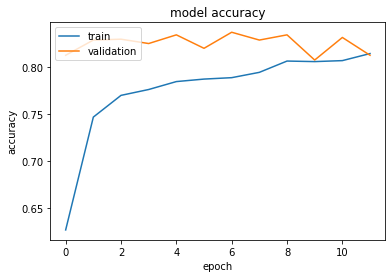

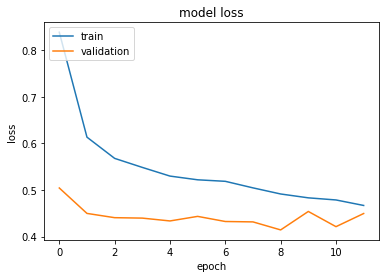

In [ ]:
#  "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [ ]:
print("Accuracy: {:.2f} %".format(accuracy_score(data_test.airline_sentiment, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.airline_sentiment, predictions, average='micro') * 100))

Accuracy: 81.83 %

F1 Score: 81.83


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


F1 Score: 81.83


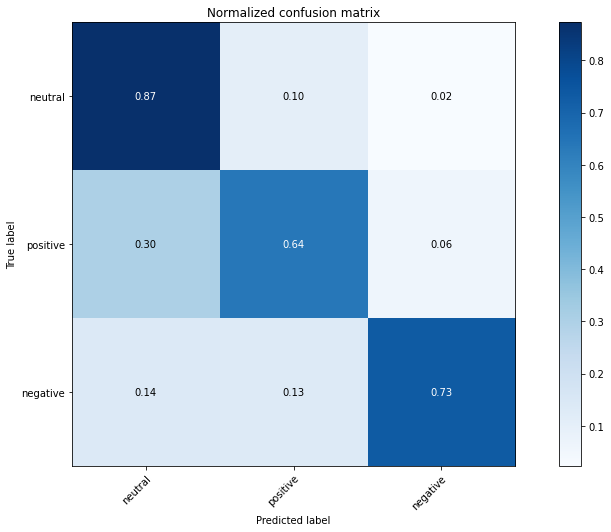

In [ ]:
print("\nF1 Score: {:.2f}".format(f1_score(data_test.airline_sentiment, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(data_test.airline_sentiment, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
print('Message: {}\nPredicted: {}'.format(X_test[4], predictions[4]))

Message:  waiting for bags now over 25min in Phl bag claim!
Predicted: negative


In [ ]:
import time

message = ['I happy']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))


Message: ['I happy']
predicted: positive (0.07 seconds)
